# Extending our first workflow

**Learning objectives of this notebook:**

- creating nodes that run arbitrary python functions
- applying the same workflow to multiple input files
- generating an output folder with a `DataSink`

***

In the previous notebook we created our first simple workflow that runs the following steps:

1. perform motion correction
2. estimate TSNR on the motion-corrected data
3. take the motion correction parameters and estimate framewise displacement

This workflow could be used as an initial quality-assurance check on all the data you collect. To do so, we need to make the workflow a bit more sophisticated. In particular, we will

1. create a node that will extract the first 50 volumes from the input data (note that you don't want to do this if you were to run the workflow as a QA step; we are doing it here to keep the running time of the workflow manageable)
2. modify the code so that the workflow can be applied to any number of input files
3. collect all output data in a single output directory


## Setup

In the next cells we are just going to import what we need, and create the nodes that we will use in our workflow.

In [1]:
import os

from nipype import Workflow, Node, IdentityInterface, Function

from nipype.interfaces import afni
from nipype.interfaces import fsl
from nipype.algorithms.confounds import FramewiseDisplacement

inputnode = Node(
    IdentityInterface(
        fields=['in_file']),
    name='inputnode'
)

outputnode = Node(
    IdentityInterface(fields=['tsnr_file', 'moco_file', 'fd']),
    name='outputnode'
)

flirt = Node(
    fsl.MCFLIRT(output_type='NIFTI_GZ', save_plots=True), 
    name='flirt'
)
fd = Node(
    FramewiseDisplacement(parameter_source='FSL'),
    name='compute_fd'
)

tsnr = Node(
    afni.TStat(outputtype='NIFTI_GZ', args='-cvarinv'),
    name='compute_tsnr'
)

## Extracting the first 50 volumes of the input data with a node

Recall that to keep the workflow running in a short time, we manually extracted the first 50 volumes of the input data. This is something you might want to do when you are debugging your workflow. 

We are going to create a node that performs the same operation with nilearn. We will use the special interface `Function`, which is able to run any arbitrary python code as a new interface. First, let's create a python function that given an input file, selects the first 50 volumes, saves the reduced file, and returns the filename of the new file.

In [2]:
def select_50_volumes(in_file):
    # NOTE: all imports **must** be inside the function that you create
    # this is because the process running the function does not inherit
    # the imports from the parent process
    from nilearn.image import index_img
    import os
    
    # it's always good practice to deal with absolute paths
    in_file = os.path.abspath(in_file)
    # get the first 50 TRs
    data_subset = index_img(in_file, slice(0, 50))
    # generate a new output filename
    # if the input file is called `infile.nii.gz`
    # the output file will be `infile_50vol.nii.gz`
    out_file = os.path.basename(in_file)
    out_file = out_file.replace('.nii.gz', '_50vol.nii.gz')
    # NOTE: the output file will be relative to the working directory
    # of the node. You should always return an absolute path
    out_file = os.path.abspath(out_file)
    # save
    data_subset.to_filename(out_file)
    # the function should (almost always) return the filename of the output file
    return out_file

Now that we created the function, we can wrap it in a `Function` interface 

In [3]:
select_volumes_interface = Function(
    # NOTE: the input names MUST match the name of your args and kwargs exactly
    input_names=['in_file'],
    output_names=['out_file'],
    function=select_50_volumes
)

And then we make it a `Node`

In [4]:
select_volumes = Node(select_volumes_interface, name='select_volumes')

Now we are ready to plug this node into our workflow.

In [5]:
wf = Workflow(name='my_second_workflow')

wf.connect([
    # input file -> select volumes
    (inputnode, select_volumes, [('in_file', 'in_file')]),
    # select volumes -> motion correction
    (select_volumes, flirt, [('out_file', 'in_file')]),
    # moco params -> framewise displacement
    (flirt, fd, [('par_file', 'in_file')]),
    # moco file -> tsnr
    (flirt, tsnr, [('out_file', 'in_file')]),
    # moco file -> output node
    (flirt, outputnode, [('out_file', 'moco_file')]),
    # tsnr file -> output node
    (tsnr, outputnode, [('out_file', 'tsnr_file')]),
    # framewise displacement -> output node
    (fd, outputnode, [('out_file', 'fd')])
])

Let's compare our two workflows

210425-14:29:17,721 nipype.workflow INFO:
	 Generated workflow graph: /home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/mysecondworkflow.png (graph2use=hierarchical, simple_form=True).


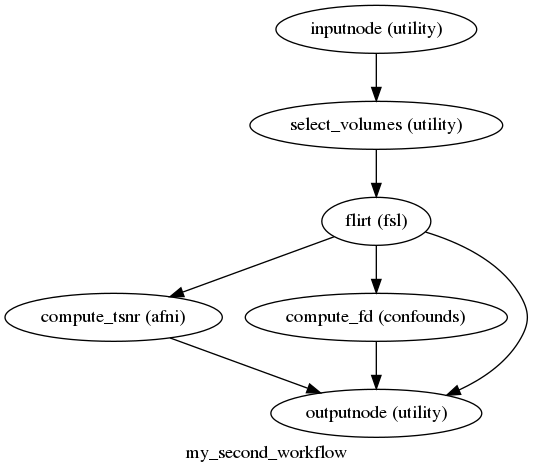

In [6]:
wf.write_graph('mysecondworkflow')

from IPython.display import Image
Image('mysecondworkflow.png')

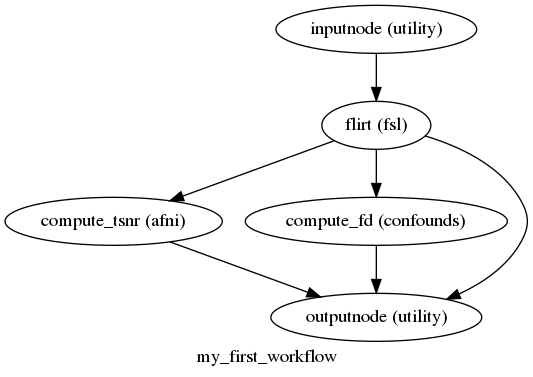

In [7]:
Image('myfirstworkflow.png')

We can see that our second workflow has an extra node between the `inputnode` and the `flirt` node called `select_volumes`, which will run the function `select_50_volumes`. Let's run it.

In [8]:
# use our previously downloaded data
data_fn = 'budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-01_bold.nii.gz'

# set up a "work directory"
wf.base_dir = os.path.abspath('./workdir')

# pass the input file
wf.inputs.inputnode.in_file = os.path.abspath(data_fn)

In [9]:
# run it
wf.run()

210425-14:29:17,784 nipype.workflow INFO:
	 Workflow my_second_workflow settings: ['check', 'execution', 'logging', 'monitoring']
210425-14:29:17,788 nipype.workflow INFO:
	 Running serially.
210425-14:29:17,789 nipype.workflow INFO:
	 [Node] Setting-up "my_second_workflow.select_volumes" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_second_workflow/select_volumes".
210425-14:29:17,791 nipype.workflow INFO:
	 [Node] Running "select_volumes" ("nipype.interfaces.utility.wrappers.Function")
210425-14:29:21,958 nipype.workflow INFO:
	 [Node] Finished "my_second_workflow.select_volumes".
210425-14:29:21,959 nipype.workflow INFO:
	 [Node] Setting-up "my_second_workflow.flirt" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_second_workflow/flirt".
210425-14:29:21,962 nipype.workflow INFO:
	 [Node] Running "flirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_second_

Cool, it ran without errors! Let's see what the outputs are in our working directory

In [10]:
!tree workdir/my_second_workflow/

workdir/my_second_workflow/
├── compute_fd
│   ├── _0x26a0ccdba478eedff347158bf0237f4b.json
│   ├── fd_power_2012.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   └── result_compute_fd.pklz
├── compute_tsnr
│   ├── _0x5d508226dfbe72edea1f784b19dc1a60.json
│   ├── command.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── result_compute_tsnr.pklz
│   └── sub-sid000021_task-movie_run-01_bold_50vol_mcf_tstat.nii.gz
├── d3.js
├── flirt
│   ├── _0x90da524ac67ca0c952bd02ec72e985c2.json
│   ├── command.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── result_flirt.pklz
│   ├── sub-sid000021_task-movie_run-01_bold_50vol_mcf.nii.gz
│   └── sub-sid000021_task-movie_run-01_bold_50vol_mcf.nii.gz.par
├── graph1.json
├── graph.json
├── index.html
└── select_volumes
    ├── _0x95beafca00a36ed15d3d822c22dcfbe4.json
    ├── _inputs.pklz
    ├── _node.pklz
    ├── _report
    │   └── re

We can see that there's an extra folder called `select_volumes` with an output called `sub-sid000021_task-movie_run-01_bold_50vol.nii.gz`. Let's check the shape of this dataset.

In [11]:
import nibabel as nib

fn = 'workdir/my_second_workflow/select_volumes/sub-sid000021_task-movie_run-01_bold_50vol.nii.gz'
img = nib.load(fn)
print(f"{fn.split('/')[-1]} has shape {img.shape}")

sub-sid000021_task-movie_run-01_bold_50vol.nii.gz has shape (96, 96, 48, 50)


So our node with custom python code worked!

## Iterating our workflow over multiple files

We created a small (but useful!) workflow to generate some QA files. However, our workflow takes a single file as an input. There's no reason why we shouldn't be able to apply this workflow to any number of input files. There are multiple ways to accomplish this. I will show my favorite way (which is inspired by how it's coded in [fMRIPrep](https://fmriprep.org/en/stable/)). It's by no means the "correct" way.


### Fixing output filenames
First, we need to fix the output filenames of our current workflow. When we want to iterate the same workflow over a number of input files, it's better if the output files are unique. All our nodes except one are generating unique output filenames (scroll up to see what the work directory contains). We need to fix the node that computes framewise displacement:

In [118]:
!tree workdir/my_second_workflow/compute_fd/

workdir/my_second_workflow/compute_fd/
├── _0x26a0ccdba478eedff347158bf0237f4b.json
├── fd_power_2012.txt
├── _inputs.pklz
├── _node.pklz
├── _report
│   └── report.rst
└── result_compute_fd.pklz

1 directory, 6 files


In our example the input file is called `sub-sid000021_task-movie_run-01_bold.nii.gz`, but the output file of this node is called `fd_power_2012.txt`. A more reasonable (and unique) output filename would be `sub-sid000021_task-movie_run-01_fd.txt`. How to do this?

Let's check the parameters of the interface `FramewiseDisplacement`:

In [13]:
FramewiseDisplacement.help()

Calculate the :abbr:`FD (framewise displacement)` as in [Power2012]_.
This implementation reproduces the calculation in fsl_motion_outliers

.. [Power2012] Power et al., Spurious but systematic correlations in functional
     connectivity MRI networks arise from subject motion, NeuroImage 59(3),
     2012. doi:`10.1016/j.neuroimage.2011.10.018
     <https://doi.org/10.1016/j.neuroimage.2011.10.018>`_.

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                motion parameters
        parameter_source: ('FSL' or 'AFNI' or 'SPM' or 'FSFAST' or 'NIPY')
                Source of movement parameters

        [Optional]
        radius: (a float, nipype default value: 50)
                radius in mm to calculate angular FDs, 50mm is the default since it
                is used in Power et al. 2012
        out_file: (a pathlike object or string representing a file, nipype
                  default value: fd_power_2012.txt)
    

We can see that it has an optional input parameter called `out_file`. This parameter by default is set to `fd_power_2012.txt`, but it can be changed to any string we want. 

For simplicity we will assume that our input file is formatted according to the [BIDS standard](https://bids-specification.readthedocs.io/en/stable/). Thus, given an input file such as `sub-sid000021_task-movie_run-01_bold.nii.gz`, we can generate a unique output file for the framewise displacement node by replacing `_bold.nii.gz` with `_fd.txt`. 

This can be easily accomplished using an advanced feature of Nipype, which allows arbitrary functions to be applied to any output of a node. The syntax can be a bit (more) convoluted, but it will become natural with enough practice.

Say that we are linking our `inputnode` to the `compute_fd` node by passing `inputnode.in_file` to `compute_fd.out_file`. Without any extra operation, we would connect them as follows:

```python
wf.connect([
    (inputnode, fd, [('in_file', 'out_file')])
])
```

Now say we have defined a function that performs the string replacement that we want:

```python
def make_fd_outfile(fn):
    # NOTE: imports must be defined inside the function
    import os
    # take only the basename, otherwise the output will be
    # in the same directory as the input filename
    fn = os.path.basename(fn)
    fn = fn.replace('_bold.nii.gz', '_fd.txt')
    return fn
```

we can apply this function to `inputnode.in_file` with the following syntax:

```python
wf.connect([
    (inputnode, fd, [(('in_file', make_fd_outfile), 'out_file')])
])
```

note that we have replaced `'in_file'` with the tuple `('in_file', make_fd_outfile)`. This will tell Nipype to take `inputnode.in_file`, pass it to `make_fd_outfile`, and then pass the output to `compute_fd.out_file`. 

Let's try it out.

In [14]:
def make_fd_outfile(fn):
    # NOTE: imports must be defined inside the function
    import os
    # take only the basename, otherwise the output will be
    # in the same directory as the input filename
    fn = os.path.basename(fn)
    fn = fn.replace('_bold.nii.gz', '_fd.txt')
    return fn

wf = Workflow(name='my_second_workflow_v2')

# make nodes
inputnode = Node(
    IdentityInterface(
        fields=['in_file']),
    name='inputnode'
)

outputnode = Node(
    IdentityInterface(fields=['tsnr_file', 'moco_file', 'fd']),
    name='outputnode'
)

flirt = Node(
    fsl.MCFLIRT(output_type='NIFTI_GZ', save_plots=True), 
    name='flirt'
)
fd = Node(
    FramewiseDisplacement(parameter_source='FSL'),
    name='compute_fd'
)

tsnr = Node(
    afni.TStat(outputtype='NIFTI_GZ', args='-cvarinv'),
    name='compute_tsnr'
)

select_volumes_interface = Function(
    # NOTE: the input names MUST match the name of your args and kwargs exactly
    input_names=['in_file'],
    output_names=['out_file'],
    function=select_50_volumes
)
select_volumes = Node(select_volumes_interface, name='select_volumes')

wf.connect([
    # input file -> select volumes
    (inputnode, select_volumes, [('in_file', 'in_file')]),
    # input_file -> fd out_file to generate unique filename
    (inputnode, fd, [(('in_file', make_fd_outfile), 'out_file')]),
    # select volumes -> motion correction
    (select_volumes, flirt, [('out_file', 'in_file')]),
    # moco params -> framewise displacement
    (flirt, fd, [('par_file', 'in_file')]),
    # moco file -> tsnr
    (flirt, tsnr, [('out_file', 'in_file')]),
    # moco file -> output node
    (flirt, outputnode, [('out_file', 'moco_file')]),
    # tsnr file -> output node
    (tsnr, outputnode, [('out_file', 'tsnr_file')]),
    # framewise displacement -> output node
    (fd, outputnode, [('out_file', 'fd')])
])

Let's check how this new workflow looks like

210425-14:29:35,860 nipype.workflow INFO:
	 Generated workflow graph: /home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/mysecondworkflow_v2.png (graph2use=hierarchical, simple_form=True).


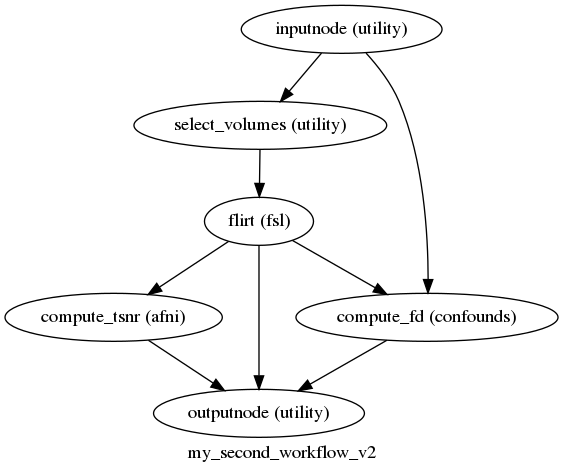

In [15]:
wf.write_graph('mysecondworkflow_v2')

from IPython.display import Image
Image('mysecondworkflow_v2.png')

And now let's try to run it.

In [16]:
# set up a "work directory"
wf.base_dir = os.path.abspath('./workdir')

# pass the input file
wf.inputs.inputnode.in_file = os.path.abspath(data_fn)
wf.run()

210425-14:29:35,871 nipype.workflow INFO:
	 Workflow my_second_workflow_v2 settings: ['check', 'execution', 'logging', 'monitoring']
210425-14:29:35,877 nipype.workflow INFO:
	 Running serially.
210425-14:29:35,878 nipype.workflow INFO:
	 [Node] Setting-up "my_second_workflow_v2.select_volumes" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_second_workflow_v2/select_volumes".
210425-14:29:35,881 nipype.workflow INFO:
	 [Node] Running "select_volumes" ("nipype.interfaces.utility.wrappers.Function")
210425-14:29:39,831 nipype.workflow INFO:
	 [Node] Finished "my_second_workflow_v2.select_volumes".
210425-14:29:39,832 nipype.workflow INFO:
	 [Node] Setting-up "my_second_workflow_v2.flirt" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_second_workflow_v2/flirt".
210425-14:29:39,836 nipype.workflow INFO:
	 [Node] Running "flirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/

Let's check the outputs now:

In [17]:
!tree workdir/my_second_workflow_v2/compute_fd/

workdir/my_second_workflow_v2/compute_fd/
├── _0xbd268e116f96bfbc4fe54ad03929e467.json
├── _inputs.pklz
├── _node.pklz
├── _report
│   └── report.rst
├── result_compute_fd.pklz
└── sub-sid000021_task-movie_run-01_fd.txt

1 directory, 6 files


Great! Now this workflow will generate unique output filenames.

### Looping over multiple input files

To loop over multiple input files, we will first create a "parent" (or main) workflow. Then, for every input file, we will create a subworkflow that will process the input file. We will add the subworkflow to the parent workflow. In this way, we will be able to use the parallel processing feature of Nipype. 

Let's get started.

First, we'll create a function that initializes a new subworkflow. This subworkflow will perform the processes that we tested so far.

In [18]:
def make_fd_outfile(fn):
    # NOTE: imports must be defined inside the function
    import os
    # take only the basename, otherwise the output will be
    # in the same directory as the input filename
    fn = os.path.basename(fn)
    fn = fn.replace('_bold.nii.gz', '_fd.txt')
    return fn


# Note that we are simply wrapping our previous code in a function
# and adding a docstring :-)
def init_qa_wf(name):
    """Initialize a QA workflow that computes temporal SNR on the first 50 motion-corrected 
    volumes of the input file. It also computes framewise displacement.
    
    Arguments
    ---------
    name : str
        name of the workflow
        
    Returns
    -------
    wf : nipype.Workflow
    
    Inputs
    ------
    in_file
        Path to the input EPI file.
 
    Outputs
    -------
    tsnr_file
        tSNR volume of the first 50 TRs.
    moco_file
        Motion-corrected volume.
    fd
        File containing framewise displacement values.
    """
    wf = Workflow(name=name)
    # make nodes
    inputnode = Node(
        IdentityInterface(
            fields=['in_file']),
        name='inputnode'
    )

    outputnode = Node(
        IdentityInterface(fields=['tsnr_file', 'moco_file', 'fd']),
        name='outputnode'
    )

    flirt = Node(
        fsl.MCFLIRT(output_type='NIFTI_GZ', save_plots=True), 
        name='flirt'
    )
    fd = Node(
        FramewiseDisplacement(parameter_source='FSL'),
        name='compute_fd'
    )

    tsnr = Node(
        afni.TStat(outputtype='NIFTI_GZ', args='-cvarinv'),
        name='compute_tsnr'
    )

    select_volumes_interface = Function(
        # NOTE: the input names MUST match the name of your args and kwargs exactly
        input_names=['in_file'],
        output_names=['out_file'],
        function=select_50_volumes
    )
    select_volumes = Node(select_volumes_interface, name='select_volumes')

    # connect everything
    wf.connect([
        # input file -> select volumes
        (inputnode, select_volumes, [('in_file', 'in_file')]),
        # input_file -> fd out_file to generate unique filename
        (inputnode, fd, [(('in_file', make_fd_outfile), 'out_file')]),
        # select volumes -> motion correction
        (select_volumes, flirt, [('out_file', 'in_file')]),
        # moco params -> framewise displacement
        (flirt, fd, [('par_file', 'in_file')]),
        # moco file -> tsnr
        (flirt, tsnr, [('out_file', 'in_file')]),
        # moco file -> output node
        (flirt, outputnode, [('out_file', 'moco_file')]),
        # tsnr file -> output node
        (tsnr, outputnode, [('out_file', 'tsnr_file')]),
        # framewise displacement -> output node
        (fd, outputnode, [('out_file', 'fd')])
    ])
    return wf

With this function, we will loop through all our input files, generate a new subworkflow, and add it to the parent workflow.

Let's get first some input files:

In [21]:
from glob import glob
in_files = sorted(glob('budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-*_bold.nii.gz'))
print('\n'.join(in_files))

budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-01_bold.nii.gz
budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-02_bold.nii.gz
budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-03_bold.nii.gz
budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-04_bold.nii.gz
budapest-data/sub-sid000021/func/sub-sid000021_task-movie_run-05_bold.nii.gz


Now, let's create a new subworkflow for each of these input files:

In [27]:
main_wf = Workflow('my_main_workflow')
for in_file in in_files:
    # Let's generate a short unique name for each input file
    wf_name = os.path.basename(in_file).replace('_bold.nii.gz', '_wf')
    # remove dashes to clear up the name
    wf_name = wf_name.replace('-', '')
    print(f"Creating workflow {wf_name}")
    # Create a subworkflow
    wf = init_qa_wf(wf_name)
    # Pass the input file
    wf.inputs.inputnode.in_file = os.path.abspath(in_file)
    # add to the main workflow
    main_wf.add_nodes([wf])

Creating workflow subsid000021_taskmovie_run01_wf
Creating workflow subsid000021_taskmovie_run02_wf
Creating workflow subsid000021_taskmovie_run03_wf
Creating workflow subsid000021_taskmovie_run04_wf
Creating workflow subsid000021_taskmovie_run05_wf


Let's now see what we have created

In [28]:
main_wf.write_graph('mymainworkflow_v1')

210425-15:41:24,725 nipype.workflow INFO:
	 Generated workflow graph: /home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/mymainworkflow_v1.png (graph2use=hierarchical, simple_form=True).


'/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/mymainworkflow_v1.png'

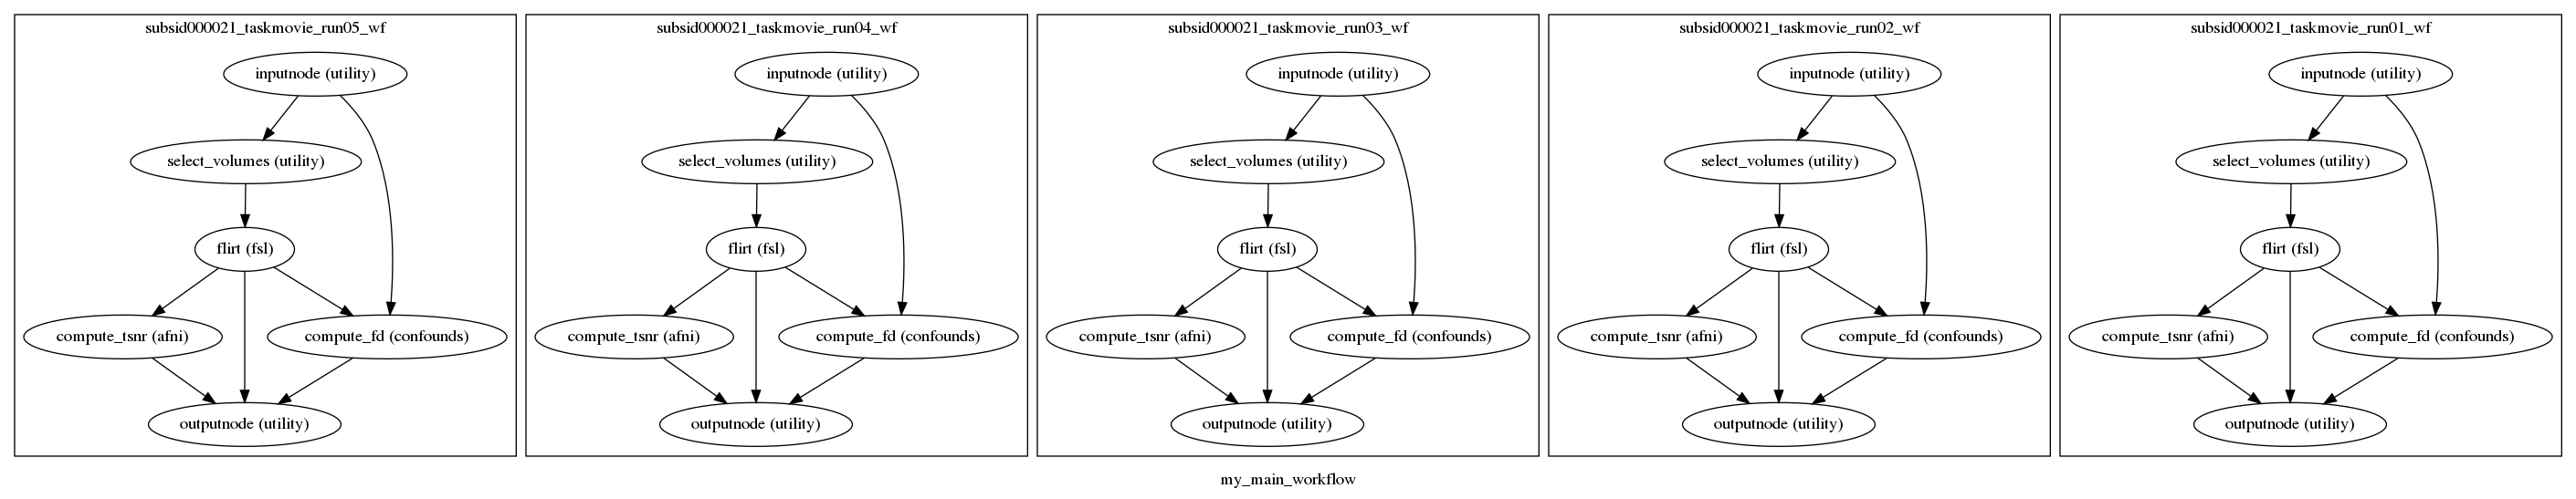

In [29]:
Image('mymainworkflow_v1.png')

OK, that looks reasonable. We have created five copies of the same workflow. Now we are ready to run it in parallel using multiprocessing. But first, we need to get the data with datalad.

In [119]:
import datalad.api as dl
_ = dl.get(in_files)  # do not return anything

And now we are ready to run the workflow. Note that we are running this workflow using the `MultiProc` plugin, which will use multiprocessing. See [this tutorial](https://miykael.github.io/nipype_tutorial/notebooks/basic_plugins.html) for other available plugins (such as slurm).

In [33]:
# first set the work directory
main_wf.base_dir = './workdir'
main_wf.run(
    # which plugin to use,
    # see also https://miykael.github.io/nipype_tutorial/notebooks/basic_plugins.html
    plugin='MultiProc', 
    plugin_args={'n_procs': 6}
)

210425-15:46:58,258 nipype.workflow INFO:
	 Workflow my_main_workflow settings: ['check', 'execution', 'logging', 'monitoring']
210425-15:46:58,268 nipype.workflow INFO:
	 Running in parallel.
210425-15:46:58,271 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 56.54/56.54, Free processors: 6/6.
210425-15:46:58,389 nipype.workflow INFO:
	 [Job 0] Cached (my_main_workflow.subsid000021_taskmovie_run01_wf.select_volumes).
210425-15:46:58,428 nipype.workflow INFO:
	 [Node] Setting-up "my_main_workflow.subsid000021_taskmovie_run02_wf.select_volumes" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_main_workflow/subsid000021_taskmovie_run02_wf/select_volumes".
210425-15:46:58,429 nipype.workflow INFO:
	 [Node] Setting-up "my_main_workflow.subsid000021_taskmovie_run03_wf.select_volumes" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_main_workflow/subsid000021_taskmovie_run03_wf/select_volumes".
210425-15:46:58,431 nipype.workflow I

Let's check the output in the work directory:

In [34]:
!tree workdir/my_main_workflow/

workdir/my_main_workflow/
├── d3.js
├── graph1.json
├── graph.json
├── index.html
├── subsid000021_taskmovie_run01_wf
│   ├── compute_fd
│   │   ├── _0x799816806f85d3beece22d53e599ef32.json
│   │   ├── _inputs.pklz
│   │   ├── _node.pklz
│   │   ├── _report
│   │   │   └── report.rst
│   │   ├── result_compute_fd.pklz
│   │   └── sub-sid000021_task-movie_run-01_fd.txt
│   ├── compute_tsnr
│   │   ├── _0x2ce338ca94db519cad22c3051b2ca09f.json
│   │   ├── command.txt
│   │   ├── _inputs.pklz
│   │   ├── _node.pklz
│   │   ├── _report
│   │   │   └── report.rst
│   │   ├── result_compute_tsnr.pklz
│   │   └── sub-sid000021_task-movie_run-01_bold_50vol_mcf_tstat.nii.gz
│   ├── flirt
│   │   ├── _0x0dc03926e55466fa3330b6d08af62d0f.json
│   │   ├── command.txt
│   │   ├── _inputs.pklz
│   │   ├── _node.pklz
│   │   ├── _report
│   │   │   └── report.rst
│   │   ├── result_flirt.pklz
│   │   ├── sub-sid000021_task-movie_run-01_bold_50vol_mcf.nii.gz
│   │   └── sub-sid000021_task-movie_run-01_b

Great, it looks like all the outputs were generated correctly. We are now one step closer to finishing our pipeline. We just need to collect everything in a single output directory, so we don't have to deal with navigating the work directory.

### Using a DataSink to collect outputs

To collect all our outputs in a single output directory, we can use a special interface called `DataSink`. This interface will collect in a directory whatever output of a node we decide to link to it. Thus, we only need to modify our code slightly to collect all the outputs from each subworkflow into the `DataSink`. 

In [120]:
# Create a DataSink node
from nipype.interfaces import DataSink
sinker = Node(DataSink(), 'sinker')

# This is going to be our output directory
sinker.inputs.base_directory = os.path.abspath('derivatives')

In [103]:
# NOTE: most of this code is the same as before
main_wf = Workflow('my_main_workflow')
for in_file in in_files:
    # Let's generate a short unique name for each input file
    wf_name = os.path.basename(in_file).replace('_bold.nii.gz', '_wf')
    # remove dashes to clear up the name
    wf_name = wf_name.replace('-', '')
    print(f"Creating workflow {wf_name}")
    # Create a subworkflow
    wf = init_qa_wf(wf_name)
    # Pass the input file
    wf.inputs.inputnode.in_file = os.path.abspath(in_file)
    # add to the main workflow
    main_wf.add_nodes([wf])
    #########################################################################
    # NEW CODE!
    # 
    # After adding the subworkflow to the main workflow, we will link
    # the outputs to the sinker
    main_wf.connect([
        (wf, sinker, [('outputnode.fd', f'qa.@{wf_name}_fd'),
                      ('outputnode.moco_file', f'qa.@{wf_name}_moco_file'),
                      ('outputnode.tsnr_file', f'qa.@{wf_name}_tsnr_file')])
    ])

Creating workflow subsid000021_taskmovie_run01_wf
Creating workflow subsid000021_taskmovie_run02_wf
Creating workflow subsid000021_taskmovie_run03_wf
Creating workflow subsid000021_taskmovie_run04_wf
Creating workflow subsid000021_taskmovie_run05_wf


Note the syntax of the `DataSink`:

```python
    main_wf.connect([
        (wf, sinker, [('outputnode.fd', f'qa.@{wf_name}_fd'),
                      ('outputnode.moco_file', f'qa.@{wf_name}_moco_file'),
                      ('outputnode.tsnr_file', f'qa.@{wf_name}_tsnr_file')])
    ])
```

For every subworkflow `wf`, we are connecting each of the slots in the outputnode to a **uniquely named** slot in the `DataSink`. For example, for the last subworkflow we are linking `outputnode.fd` to `qa.@subsid000021_taskmovie_run05_wf_fd`. The name of the slot of the `DataSink` specifies which folders to create. Any substring (split by `.`) without an `@` sign will create a new subfolder. In the previous case, `outputnode.fd` will be saved to `./derivatives/qa`. If instead we specified `qa.subsid000021_taskmovie_run05_wf_fd` (without the `@`), `outputnode.fd` would be saved to `./derivatives/qa/subsid000021_taskmovie_run05_wf_fd`.

Let's check what the final workflow looks like:

In [104]:
main_wf.write_graph('mymainworkflow_v2')

210425-16:52:19,680 nipype.workflow INFO:
	 Generated workflow graph: /home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/mymainworkflow_v2.png (graph2use=hierarchical, simple_form=True).


'/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/mymainworkflow_v2.png'

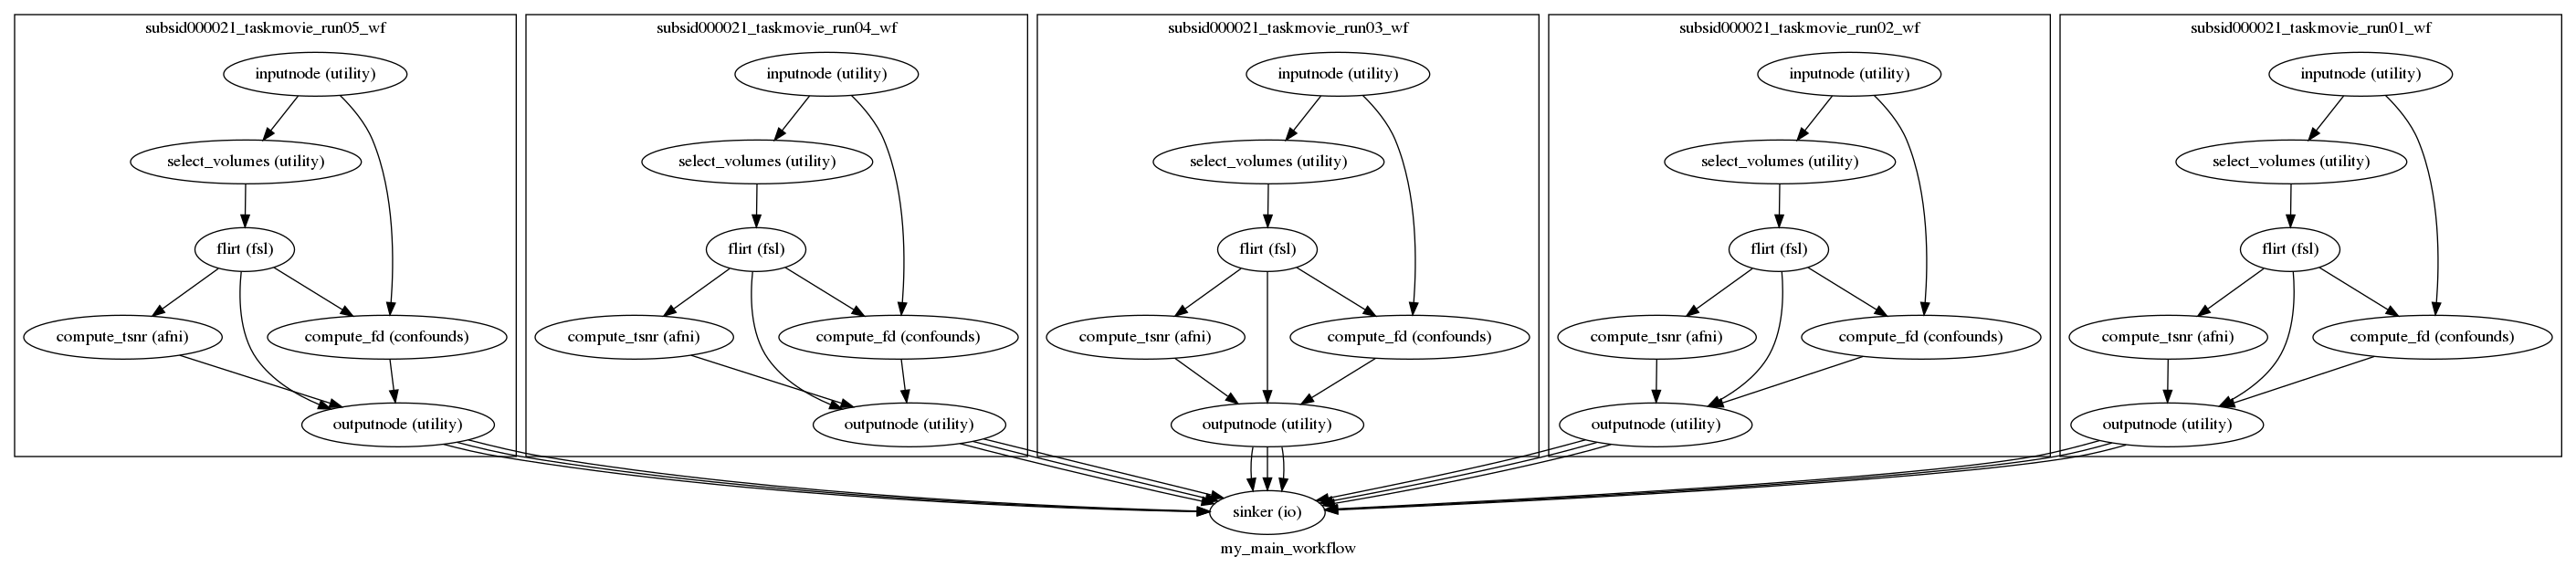

In [105]:
Image('mymainworkflow_v2.png')

That looks good. All our subworkflows are connected to the `DataSink` through each `outputnode`. Let's run this workflow again and see what gets saved in `./derivatives`.

In [108]:
main_wf.base_dir = './workdir/'
main_wf.run()

210425-16:53:37,250 nipype.workflow INFO:
	 Workflow my_main_workflow settings: ['check', 'execution', 'logging', 'monitoring']
210425-16:53:37,264 nipype.workflow INFO:
	 Running serially.
210425-16:53:37,265 nipype.workflow INFO:
	 [Node] Setting-up "my_main_workflow.subsid000021_taskmovie_run01_wf.select_volumes" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_main_workflow/subsid000021_taskmovie_run01_wf/select_volumes".
210425-16:53:37,267 nipype.workflow INFO:
	 [Node] Cached "my_main_workflow.subsid000021_taskmovie_run01_wf.select_volumes" - collecting precomputed outputs
210425-16:53:37,268 nipype.workflow INFO:
	 [Node] "my_main_workflow.subsid000021_taskmovie_run01_wf.select_volumes" found cached.
210425-16:53:37,270 nipype.workflow INFO:
	 [Node] Setting-up "my_main_workflow.subsid000021_taskmovie_run01_wf.flirt" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_main_workflow/subsid000021_taskmovie_run01_wf/flirt".
210425-16:53:37,276 nipype.workflow INFO

You probably noticed that this time the workflow ran really fast. This is because all the output nodes were already cached in the work directory, so the only node that had to be run was the `DataSink` node.

Let's check the derivatives folder

In [110]:
!tree derivatives/

derivatives/
└── qa
    ├── sub-sid000021_task-movie_run-01_bold_50vol_mcf.nii.gz
    ├── sub-sid000021_task-movie_run-01_bold_50vol_mcf_tstat.nii.gz
    ├── sub-sid000021_task-movie_run-01_fd.txt
    ├── sub-sid000021_task-movie_run-02_bold_50vol_mcf.nii.gz
    ├── sub-sid000021_task-movie_run-02_bold_50vol_mcf_tstat.nii.gz
    ├── sub-sid000021_task-movie_run-02_fd.txt
    ├── sub-sid000021_task-movie_run-03_bold_50vol_mcf.nii.gz
    ├── sub-sid000021_task-movie_run-03_bold_50vol_mcf_tstat.nii.gz
    ├── sub-sid000021_task-movie_run-03_fd.txt
    ├── sub-sid000021_task-movie_run-04_bold_50vol_mcf.nii.gz
    ├── sub-sid000021_task-movie_run-04_bold_50vol_mcf_tstat.nii.gz
    ├── sub-sid000021_task-movie_run-04_fd.txt
    ├── sub-sid000021_task-movie_run-05_bold_50vol_mcf.nii.gz
    ├── sub-sid000021_task-movie_run-05_bold_50vol_mcf_tstat.nii.gz
    └── sub-sid000021_task-movie_run-05_fd.txt

1 directory, 15 files


This is looking good, and we could stop here. However, some filenames are a bit confusing. For example, we might want the motion corrected outputs to be called

```
sub-sid000021_task-movie_run-0[1-5]_bold_moco.nii.gz
```

We might also want the filename of the tSNR volumes to be more informative, like

```
sub-sid000021_task-movie_run-0[1-5]_bold_tsnr.nii.gz
```

We can achieve this by specifying string substitutions in the `DataSink`, so that the output filenames will be better named. 

In [113]:
# Create a DataSink node
sinker = Node(DataSink(), 'sinker')
# This is going to be our output directory
sinker.inputs.base_directory = os.path.abspath('derivatives2')

# Specify string substitutions. These are simply tuples indicating
# ('substring', 'replacement')
# as you would specify when using the `str.replace` method.
# 
# Note that the substitutions will be run in the order in which they are 
# passed.
sinker.inputs.substitutions = [
    ('50vol_mcf_tstat', 'tsnr'),
    ('50vol_mcf', 'moco')
]

In [114]:
# NOTE: most of this code is the same as before
main_wf = Workflow('my_main_workflow')
for in_file in in_files:
    # Let's generate a short unique name for each input file
    wf_name = os.path.basename(in_file).replace('_bold.nii.gz', '_wf')
    # remove dashes to clear up the name
    wf_name = wf_name.replace('-', '')
    print(f"Creating workflow {wf_name}")
    # Create a subworkflow
    wf = init_qa_wf(wf_name)
    # Pass the input file
    wf.inputs.inputnode.in_file = os.path.abspath(in_file)
    # add to the main workflow
    main_wf.add_nodes([wf])
    # After adding the subworkflow to the main workflow, we will link
    # the outputs to the sinker
    main_wf.connect([
        (wf, sinker, [('outputnode.fd', f'qa.@{wf_name}_fd'),
                      ('outputnode.moco_file', f'qa.@{wf_name}_moco_file'),
                      ('outputnode.tsnr_file', f'qa.@{wf_name}_tsnr_file')])
    ])

Creating workflow subsid000021_taskmovie_run01_wf
Creating workflow subsid000021_taskmovie_run02_wf
Creating workflow subsid000021_taskmovie_run03_wf
Creating workflow subsid000021_taskmovie_run04_wf
Creating workflow subsid000021_taskmovie_run05_wf


In [116]:
# let's run the workflow
main_wf.base_dir = './workdir/'
main_wf.run()

210425-17:02:02,287 nipype.workflow INFO:
	 Workflow my_main_workflow settings: ['check', 'execution', 'logging', 'monitoring']
210425-17:02:02,300 nipype.workflow INFO:
	 Running serially.
210425-17:02:02,302 nipype.workflow INFO:
	 [Node] Setting-up "my_main_workflow.subsid000021_taskmovie_run01_wf.select_volumes" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_main_workflow/subsid000021_taskmovie_run01_wf/select_volumes".
210425-17:02:02,304 nipype.workflow INFO:
	 [Node] Cached "my_main_workflow.subsid000021_taskmovie_run01_wf.select_volumes" - collecting precomputed outputs
210425-17:02:02,305 nipype.workflow INFO:
	 [Node] "my_main_workflow.subsid000021_taskmovie_run01_wf.select_volumes" found cached.
210425-17:02:02,306 nipype.workflow INFO:
	 [Node] Setting-up "my_main_workflow.subsid000021_taskmovie_run01_wf.flirt" in "/home/jlg/mvdoc/repos/mvdoc-nipype-tutorial/workdir/my_main_workflow/subsid000021_taskmovie_run01_wf/flirt".
210425-17:02:02,309 nipype.workflow INFO

And now we are ready to check the output

In [117]:
!tree derivatives2/

derivatives2/
└── qa
    ├── sub-sid000021_task-movie_run-01_bold_moco.nii.gz
    ├── sub-sid000021_task-movie_run-01_bold_tsnr.nii.gz
    ├── sub-sid000021_task-movie_run-01_fd.txt
    ├── sub-sid000021_task-movie_run-02_bold_moco.nii.gz
    ├── sub-sid000021_task-movie_run-02_bold_tsnr.nii.gz
    ├── sub-sid000021_task-movie_run-02_fd.txt
    ├── sub-sid000021_task-movie_run-03_bold_moco.nii.gz
    ├── sub-sid000021_task-movie_run-03_bold_tsnr.nii.gz
    ├── sub-sid000021_task-movie_run-03_fd.txt
    ├── sub-sid000021_task-movie_run-04_bold_moco.nii.gz
    ├── sub-sid000021_task-movie_run-04_bold_tsnr.nii.gz
    ├── sub-sid000021_task-movie_run-04_fd.txt
    ├── sub-sid000021_task-movie_run-05_bold_moco.nii.gz
    ├── sub-sid000021_task-movie_run-05_bold_tsnr.nii.gz
    └── sub-sid000021_task-movie_run-05_fd.txt

1 directory, 15 files


This looks really good and organized :-)

## A final step

As a final step, let's just check what we have generated. Let's plot the framewise displacement for each run (for the first 50 volumes):

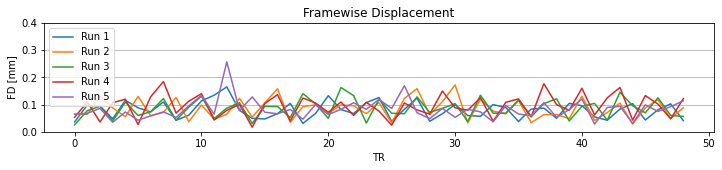

In [124]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fd_files = sorted(glob('derivatives2/qa/*.txt'))
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

for i, fd_fn in enumerate(fd_files, 1):
    fd_data = np.loadtxt(fd_fn, skiprows=1)
    ax.plot(fd_data, label=f'Run {i}')
ax.set_ylim([0, .4])
ax.set_ylabel('FD [mm]')
ax.set_xlabel('TR')
ax.grid(axis='y')
ax.legend()
_ = ax.set_title('Framewise Displacement')